In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from datetime import date, datetime


In [14]:
df = pd.read_csv('MSFT_stock_data.csv')
df=df.set_index('Date')

In [15]:
df['target'] = df.Close - df.drift
df

,Open,High,Low,Close,Volume,drift,target
Date,,,,,,,
2020-01-02 00:00:00-05:00,153.641577,155.528468,153.206143,155.422028,22622100,172.455212,-17.033184
2020-01-03 00:00:00-05:00,153.196476,154.773716,152.944880,153.486755,21116200,172.612976,-19.126220
2020-01-06 00:00:00-05:00,151.996577,153.951210,151.445017,153.883469,20813700,172.770884,-18.887415
2020-01-07 00:00:00-05:00,154.164119,154.502783,152.228842,152.480423,21634100,172.928936,-20.448513
2020-01-08 00:00:00-05:00,153.786731,155.596225,152.838450,154.909195,27746500,173.087134,-18.177939
...,...,...,...,...,...,...,...
2023-06-05 00:00:00-04:00,335.220001,338.559998,334.660004,335.940002,21307100,378.959431,-43.019429
2023-06-06 00:00:00-04:00,335.329987,335.369995,332.170013,333.679993,20396200,379.306107,-45.626114
2023-06-07 00:00:00-04:00,331.649994,334.489990,322.500000,323.380005,40717100,379.653100,-56.273095


In [16]:
sc = StandardScaler()
data_scaled = sc.fit_transform(df) #scaling using sklearn gives list rather than DataFrame.
data_scaled = pd.DataFrame(data_scaled,columns = df.columns) # we create a DataFrame from the above list
data_scaled.index = df.index
data_scaled

,Open,High,Low,Close,Volume,drift,target
Date,,,,,,,
2020-01-02 00:00:00-05:00,-1.941851,-1.956931,-1.902825,-1.908534,-0.674104,-1.512309,-0.006497
2020-01-03 00:00:00-05:00,-1.951209,-1.972772,-1.908348,-1.949256,-0.788424,-1.509670,-0.051776
2020-01-06 00:00:00-05:00,-1.976436,-1.990035,-1.940052,-1.940908,-0.811389,-1.507028,-0.046610
2020-01-07 00:00:00-05:00,-1.930865,-1.978459,-1.923483,-1.970432,-0.749108,-1.504384,-0.080382
2020-01-08 00:00:00-05:00,-1.938799,-1.955509,-1.910597,-1.919325,-0.285086,-1.501737,-0.031262
...,...,...,...,...,...,...,...
2023-06-05 00:00:00-04:00,1.875760,1.884643,1.932755,1.889955,-0.773932,1.942311,-0.568667
2023-06-06 00:00:00-04:00,1.878073,1.817689,1.880121,1.842399,-0.843083,1.948111,-0.625059
2023-06-07 00:00:00-04:00,1.800702,1.799219,1.675716,1.625665,0.699576,1.953915,-0.855389


# Finding correlations between sentiment and jump in stock prices

In [24]:
sentiment_df = pd.read_csv('sentiment_data_frame.csv').set_index('date')

In [25]:
sentiment_df

,negative,neutral,positive
date,,,
2020-1-1,0.184596,0.610093,0.205312
2020-1-2,0.011839,0.962005,0.026156
2020-1-3,0.078713,0.418107,0.503180
2020-1-4,0.021134,0.623070,0.355795
2020-1-5,0.182176,0.718622,0.099203
...,...,...,...
2023-6-2,0.003831,0.791215,0.204954
2023-6-3,0.143502,0.853986,0.002513
2023-6-4,0.195494,0.800462,0.004044


The stock prices are not available for weekends. So, we can either ignore the sentiments over the weekends or we can add it to Monday. Let us first simply ignore the weekend sentiments.

## Ignoring weekend sentiments

In order to combine the two dataframes, we first ensure that the index is formatted in the same way.

In [58]:
sentiment_df.index[0]

'2020-1-1'

In [43]:
data_scaled.index[0]

'2020-01-02 00:00:00-05:00'

In [73]:
test1=datetime.strptime(sentiment_df.index[1],'%Y-%m-%d')
test2=datetime.strptime(data_scaled.index[0][0:10],'%Y-%m-%d')
print(test2)
print(test1)

2020-01-02 00:00:00
2020-01-02 00:00:00


In [74]:
print(test1==test2)

True


In [76]:
dates_sentiment = []
for date in sentiment_df.index:
    dates_sentiment.append(datetime.strptime(date,'%Y-%m-%d'))

In [84]:
sentiment_df['Date'] = dates_sentiment
sentiment_df = sentiment_df.set_index('Date')

In [85]:
sentiment_df

,negative,neutral,positive
Date,,,
2020-01-01,0.184596,0.610093,0.205312
2020-01-02,0.011839,0.962005,0.026156
2020-01-03,0.078713,0.418107,0.503180
2020-01-04,0.021134,0.623070,0.355795
2020-01-05,0.182176,0.718622,0.099203
...,...,...,...
2023-06-02,0.003831,0.791215,0.204954
2023-06-03,0.143502,0.853986,0.002513
2023-06-04,0.195494,0.800462,0.004044


In [86]:
dates_data = []
for date in data_scaled.index:
    dates_data.append(datetime.strptime(date[0:10],'%Y-%m-%d'))

In [89]:
data_scaled['Date'] = dates_data
data_scaled = data_scaled.set_index('Date')

In [90]:
data_scaled

,Open,High,Low,Close,Volume,drift,target
Date,,,,,,,
2020-01-02,-1.941851,-1.956931,-1.902825,-1.908534,-0.674104,-1.512309,-0.006497
2020-01-03,-1.951209,-1.972772,-1.908348,-1.949256,-0.788424,-1.509670,-0.051776
2020-01-06,-1.976436,-1.990035,-1.940052,-1.940908,-0.811389,-1.507028,-0.046610
2020-01-07,-1.930865,-1.978459,-1.923483,-1.970432,-0.749108,-1.504384,-0.080382
2020-01-08,-1.938799,-1.955509,-1.910597,-1.919325,-0.285086,-1.501737,-0.031262
...,...,...,...,...,...,...,...
2023-06-05,1.875760,1.884643,1.932755,1.889955,-0.773932,1.942311,-0.568667
2023-06-06,1.878073,1.817689,1.880121,1.842399,-0.843083,1.948111,-0.625059
2023-06-07,1.800702,1.799219,1.675716,1.625665,0.699576,1.953915,-0.855389


In [94]:
print(data_scaled.index[0], sentiment_df.index[1],data_scaled.index[0] == sentiment_df.index[1])

2020-01-02 00:00:00 2020-01-02 00:00:00 True


### Merging the two dataframes and ignoring weekends

In [140]:
df = pd.concat([data_scaled,sentiment_df],axis = 'columns') # combining the dataframes
df = df[np.isnan(df.Close)==False] # Remove all rows where we don't have stock information --- Weekends
df = df[np.isnan(df.negative) == False] # Removes last few days where we didn't gather sentiment data

In [141]:
df

,Open,High,Low,Close,Volume,drift,target,negative,neutral,positive
Date,,,,,,,,,,
2020-01-02,-1.941851,-1.956931,-1.902825,-1.908534,-0.674104,-1.512309,-0.006497,0.011839,0.962005,0.026156
2020-01-03,-1.951209,-1.972772,-1.908348,-1.949256,-0.788424,-1.509670,-0.051776,0.078713,0.418107,0.503180
2020-01-06,-1.976436,-1.990035,-1.940052,-1.940908,-0.811389,-1.507028,-0.046610,0.000710,0.795922,0.203369
2020-01-07,-1.930865,-1.978459,-1.923483,-1.970432,-0.749108,-1.504384,-0.080382,0.002264,0.651065,0.346672
2020-01-08,-1.938799,-1.955509,-1.910597,-1.919325,-0.285086,-1.501737,-0.031262,0.019571,0.776316,0.204114
...,...,...,...,...,...,...,...,...,...,...
2023-05-31,1.814158,1.829653,1.777813,1.731087,1.096877,1.924944,-0.709541,0.319927,0.480649,0.199424
2023-06-01,1.680442,1.779070,1.722643,1.819253,-0.358921,1.930728,-0.626377,0.298777,0.132570,0.568653
2023-06-02,1.855366,1.862395,1.888153,1.878592,-0.427996,1.936517,-0.572857,0.003831,0.791215,0.204954


### Computing the change in target variable

In [142]:
delta_target = [0]
for i in range(1,len(df)):
    delta_target.append(df.target[i]-df.target[i-1])

Now, we are in the position to compute the correlation between sentiment and change in target variable.

In [144]:
corr_neg = np.corrcoef(df.negative,delta_target)
corr_neutral = np.corrcoef(df.neutral,delta_target)
corr_pos = np.corrcoef(df.positive,delta_target)

In [145]:
print(f'''correlation with negative sentiment:
{corr_neg}
correlation with neutral sentiment:
{corr_neutral}
correlation with positive sentiment:
{corr_pos}''')

correlation with negative sentiment:
[[ 1.         -0.03480585]
 [-0.03480585  1.        ]]
correlation with neutral sentiment:
[[1.        0.0330404]
 [0.0330404 1.       ]]
correlation with positive sentiment:
[[ 1.         -0.00836946]
 [-0.00836946  1.        ]]


It seems that there is very little correlation between stock price movement and sentiment. To be sure, let us plot the two variables

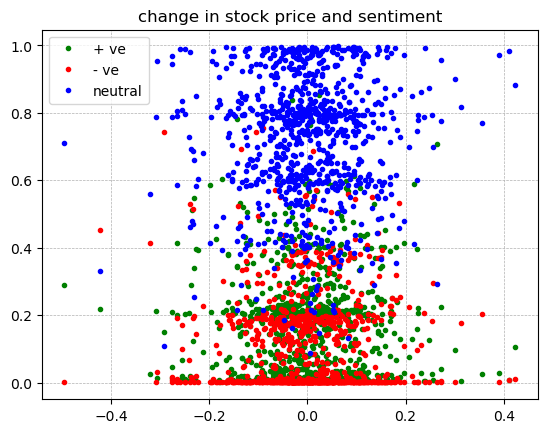

In [241]:
plt.figure(dpi = 100)
plt.plot(delta_target,df.positive,'.g',label='+ ve')
plt.plot(delta_target,df.negative,'.r',label='- ve')
plt.plot(delta_target,df.neutral,'.b',label='neutral')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.title("change in stock price and sentiment")
plt.show()

In [149]:
dominant_sentiment = []
for i in range(len(df)):
    sentiments = [df.negative[i],df.neutral[i],df.positive[i]]
    dominant_sentiment.append(sentiments.index(max(sentiments)))

In [151]:
np.corrcoef(dominant_sentiment,delta_target)

array([[1.        , 0.06573511],
       [0.06573511, 1.        ]])

It seems that there is no significant statistical correlation between sentiment and jump in stock price. Nonetheless, this is not sufficient to suggest that including sentiment can't improver performance. We need to see if there is a correlation between large values of a particular sentiment and the target variable movement.

In [220]:
df['delta_target'] = delta_target

In [236]:
experiment1_df=df[df.positive>0.5]
np.corrcoef(experiment1_df.positive,experiment1_df.delta_target)

array([[1.        , 0.17032086],
       [0.17032086, 1.        ]])

In [237]:
experiment2_df=df[df.negative>0.5]
np.corrcoef(experiment2_df.negative,experiment2_df.delta_target)

array([[ 1.        , -0.37819364],
       [-0.37819364,  1.        ]])

Clearly, we can see that there is a correlation between large values of negative and positive sentiment and the change in target variable. Hence, it would could be useful to include sentiments in our model.


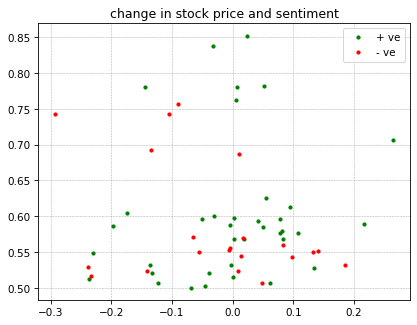

In [239]:
plt.figure(dpi = 75)
plt.plot(experiment1_df.delta_target,experiment1_df.positive,'.g',label='+ ve')
plt.plot(experiment2_df.delta_target,experiment2_df.negative,'.r',label='- ve')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.title("change in stock price and sentiment")
plt.show()